In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import beta

seed = 1234



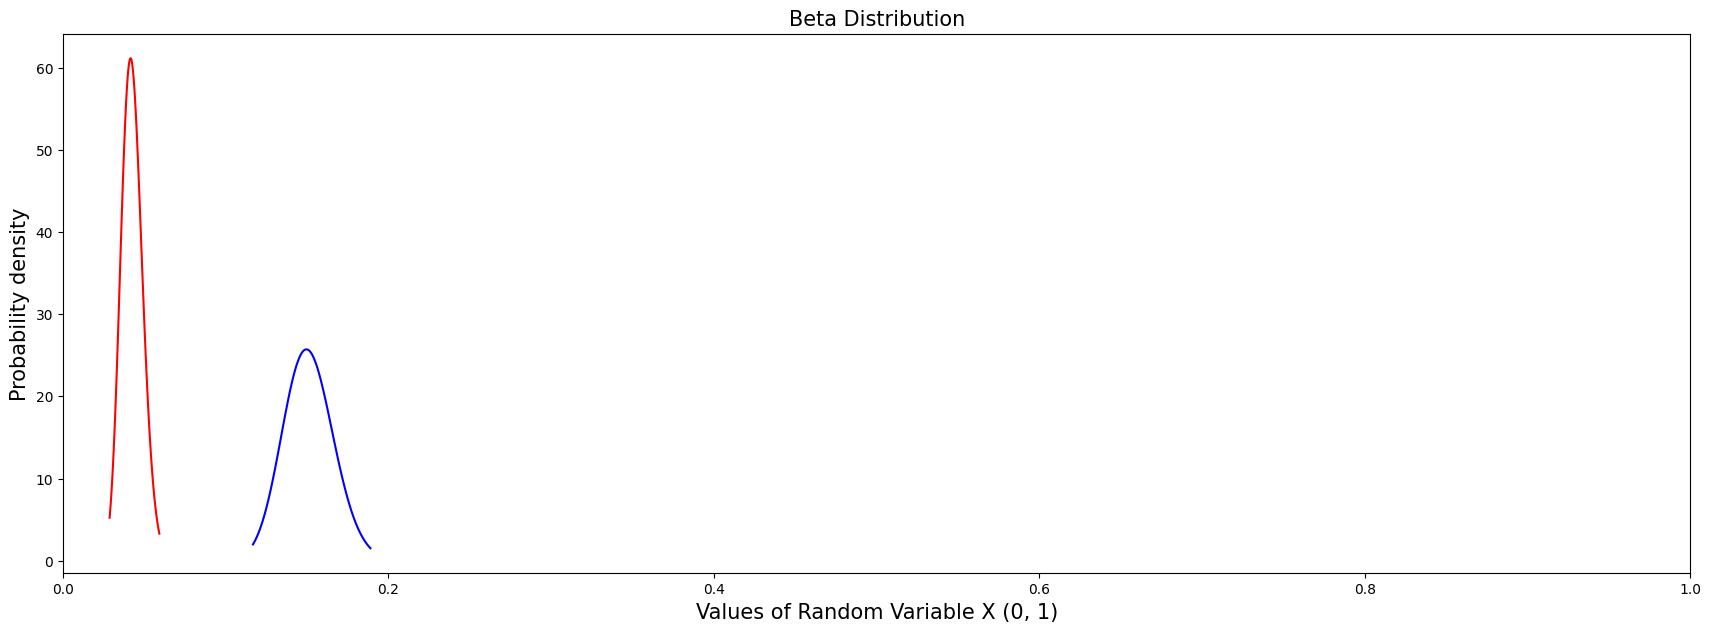

In [2]:
# Set the shape parameters
#
a1, b1 = 40, 900
a2, b2 = 80, 450

# Generate the value between
#
x1 = np.linspace(beta.ppf(0.01, a1, b1),beta.ppf(0.99, a1, b1), 100)
x2 = np.linspace(beta.ppf(0.01, a2, b2),beta.ppf(0.99, a2, b2), 100)

# Plot the beta distribution
#
plt.figure(figsize=(21,7))
plt.xlim(0, 1)
plt.plot(x1, beta.pdf(x1, a1, b1), 'r-')
plt.plot(x2, beta.pdf(x2, a2, b2), 'b-')
plt.title('Beta Distribution', fontsize='15')
plt.xlabel('Values of Random Variable X (0, 1)', fontsize='15')
plt.ylabel('Probability density', fontsize='15')
plt.show()

In [3]:
# setting the seed for reproducibility
np.random.seed(seed)

parameter_estimation_sample = beta.rvs(a1, b1, size=100)
stable_sample = beta.rvs(a1, b1, size=10000)
novelty_sample = beta.rvs(a2, b2, size=5000)


In [4]:
beta.fit(parameter_estimation_sample, method="MM")

c:\Users\super\anaconda3\envs\omop\Lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
c:\Users\super\anaconda3\envs\omop\Lib\site-packages\scipy\stats\_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


(44979132.98436591, 61.77204973476411, -34175.366571993596, 34174.621780841015)

In [5]:
from typing import List
from src.change_detector.stats_and_distance.stats_and_distance import iter_geo_mean_estimator, geo_mean

def update_geo_mean_estimators(new_dist: float, dist_geo_mean, complementary_dist_geo_mean, run_order:int = 1, order_limit:int|None = None) -> (float, float):
    dist_geo_mean, complementary_dist_geo_mean = (
        iter_geo_mean_estimator(x1, run_order, x2, order_limit=order_limit) for x1, x2 in
        [(new_dist, dist_geo_mean), (1-new_dist, complementary_dist_geo_mean)]
    )
    return dist_geo_mean, complementary_dist_geo_mean

def update_beta_distribution_parameters(
                            new_dist: float, 
                            run_order:int, 
                            old_dist_geo_mean:float, 
                            old_complementary_dist_geo_mean:float,
                            order_limit:int|None = None
                            ) -> None:
    
    if run_order == 1:
        dist_geo_mean, complementary_dist_geo_mean = new_dist, 1-new_dist
    else:    
        dist_geo_mean, complementary_dist_geo_mean = update_geo_mean_estimators(new_dist, old_dist_geo_mean, old_complementary_dist_geo_mean, run_order, order_limit)
        estimated_alpha = 1/2+dist_geo_mean/(2*(1-dist_geo_mean-complementary_dist_geo_mean))
        estimated_beta =  1/2+complementary_dist_geo_mean/(2*(1-dist_geo_mean-complementary_dist_geo_mean))
    return estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean
    # print("new alpha:", self._estimated_alpha, "  new beta:", self._estimated_beta)
    # print("geo_mean:", self._dist_geo_mean, "  complementary geo_mean:", self._complementary_dist_geo_mean)
    
def update_beta_distribution_parameters_window(
                            distances_window:List[float]
                            ) -> None:
    dist_geo_mean, complementary_dist_geo_mean = geo_mean(distances_window), geo_mean([1-dist for dist in distances_window])
    estimated_alpha = 1/2+dist_geo_mean/(2*(1-dist_geo_mean-complementary_dist_geo_mean))
    estimated_beta =  1/2+complementary_dist_geo_mean/(2*(1-dist_geo_mean-complementary_dist_geo_mean))
    return estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean

In [6]:
from src.change_detector.stats_and_distance.stats_and_distance import geo_mean

alpha_estimates_proposed = []
beta_estimates_proposed = []

run_order = len(parameter_estimation_sample)

dist_geo_mean, complementary_dist_geo_mean = geo_mean(parameter_estimation_sample), geo_mean([1-dist for dist in parameter_estimation_sample])

for dist in stable_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean)
    alpha_estimates_proposed.append(estimated_alpha)
    beta_estimates_proposed.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)
    
    
for dist in novelty_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean)
    alpha_estimates_proposed.append(estimated_alpha)
    beta_estimates_proposed.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)

run order: 101
new alpha: 47.102585216128844   new beta: 1041.4910463252133
geo_mean: 0.03652224394174516   complementary geo_mean: 0.9634777560582548
run order: 102
new alpha: 47.155921463499986   new beta: 1044.0473827616286
geo_mean: 0.037696124750062135   complementary geo_mean: 0.9623038752499379
run order: 103
new alpha: 46.5032183621149   new beta: 1031.7775742110312
geo_mean: 0.03420868748242988   complementary geo_mean: 0.9657913125175701
run order: 104
new alpha: 46.38638445079959   new beta: 1027.4150446883725
geo_mean: 0.0505255172872312   complementary geo_mean: 0.9494744827127688
run order: 105
new alpha: 46.64795508497124   new beta: 1032.2260471780055
geo_mean: 0.047332424976423836   complementary geo_mean: 0.9526675750235761
run order: 106
new alpha: 45.24341770987474   new beta: 997.9039052475332
geo_mean: 0.05747805497313604   complementary geo_mean: 0.9425219450268639
run order: 107
new alpha: 45.46961071154732   new beta: 1001.8794026291386
geo_mean: 0.047866429028

In [7]:
alpha_estimates_truncated = []
beta_estimates_truncated = []

#set max order value, "truncating" the geo mean estimation
order_limit = 100

run_order = len(parameter_estimation_sample)

dist_geo_mean, complementary_dist_geo_mean = geo_mean(parameter_estimation_sample), geo_mean([1-dist for dist in parameter_estimation_sample])

for dist in stable_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean, order_limit)
    alpha_estimates_truncated.append(estimated_alpha)
    beta_estimates_truncated.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)
    
    
for dist in novelty_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean, order_limit)
    alpha_estimates_truncated.append(estimated_alpha)
    beta_estimates_truncated.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)

run order: 101
new alpha: 47.10103172765774   new beta: 1041.4736621035217
geo_mean: 0.03652224394174516   complementary geo_mean: 0.9634777560582548
run order: 102
new alpha: 47.15561434474234   new beta: 1044.085017005131
geo_mean: 0.037696124750062135   complementary geo_mean: 0.9623038752499379
run order: 103
new alpha: 46.484279317337396   new beta: 1031.4664600615463
geo_mean: 0.03420868748242988   complementary geo_mean: 0.9657913125175701
run order: 104
new alpha: 46.36256099274845   new beta: 1026.9240714785508
geo_mean: 0.0505255172872312   complementary geo_mean: 0.9494744827127688
run order: 105
new alpha: 46.63719765983693   new beta: 1031.975410953935
geo_mean: 0.047332424976423836   complementary geo_mean: 0.9526675750235761
run order: 106
new alpha: 45.153331279502424   new beta: 995.7114150776321
geo_mean: 0.05747805497313604   complementary geo_mean: 0.9425219450268639
run order: 107
new alpha: 45.396392599776064   new beta: 999.9912242942654
geo_mean: 0.0478664290288

In [8]:
alpha_estimates_window = []
beta_estimates_window = []

#set max order value, "truncating" the geo mean estimation
window_size= 100 #NOTE: must be smaller than starting window size of parameter_estimation_sample

run_order = len(parameter_estimation_sample)

dist_geo_mean, complementary_dist_geo_mean = geo_mean(parameter_estimation_sample), geo_mean([1-dist for dist in parameter_estimation_sample])

distances_window = parameter_estimation_sample.tolist()[-window_size:]

for dist in stable_sample:
    run_order += 1
    print("run order:", run_order)
    distances_window.append(dist)
    distances_window.pop(0)
    # print(len(distances_window))
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters_window(distances_window)
    alpha_estimates_window.append(estimated_alpha)
    beta_estimates_window.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)
    
    
for dist in novelty_sample:
    run_order += 1
    print("run order:", run_order)
    distances_window.append(dist)
    distances_window.pop(0)    
    # print(len(distances_window))
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters_window(distances_window)
    alpha_estimates_window.append(estimated_alpha)
    beta_estimates_window.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)

run order: 101
new alpha: 46.80478633775989   new beta: 1035.8599649744854
geo_mean: 0.03652224394174516   complementary geo_mean: 0.9634777560582548
run order: 102
new alpha: 46.97437523832128   new beta: 1039.3628192352942
geo_mean: 0.037696124750062135   complementary geo_mean: 0.9623038752499379
run order: 103
new alpha: 45.916594291371815   new beta: 1018.739107497084
geo_mean: 0.03420868748242988   complementary geo_mean: 0.9657913125175701
run order: 104
new alpha: 46.13366997812952   new beta: 1023.8898299654886
geo_mean: 0.0505255172872312   complementary geo_mean: 0.9494744827127688
run order: 105
new alpha: 45.959671342467665   new beta: 1019.3214824142104
geo_mean: 0.047332424976423836   complementary geo_mean: 0.9526675750235761
run order: 106
new alpha: 44.09535185514765   new beta: 974.2739662574511
geo_mean: 0.05747805497313604   complementary geo_mean: 0.9425219450268639
run order: 107
new alpha: 44.60955325691185   new beta: 986.6148734998109
geo_mean: 0.0478664290288

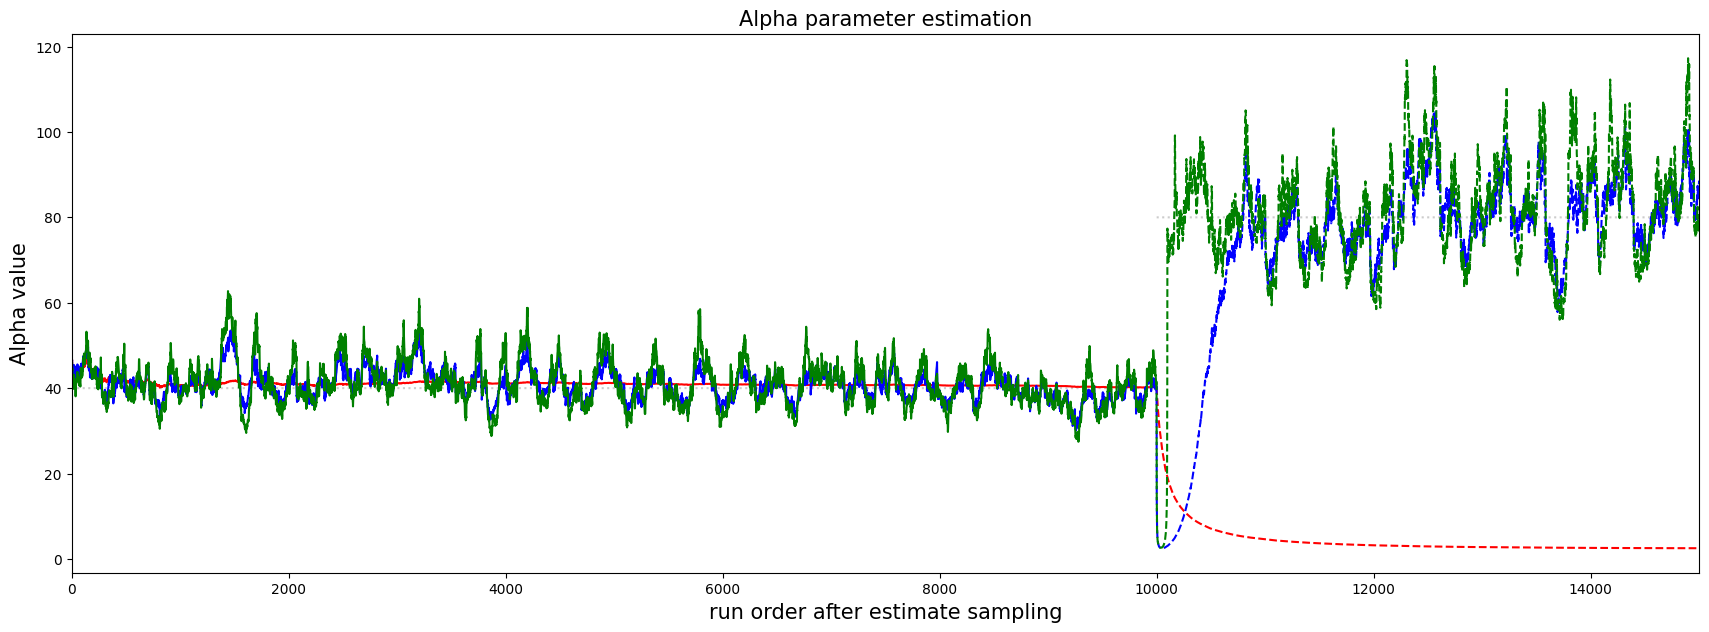

In [9]:
plt.figure(figsize=(21,7))
plt.xlim(0, 15000)
plt.plot(range(len(stable_sample)), [a1]*stable_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample),len(stable_sample)+len(novelty_sample)), [a2]*novelty_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample)), alpha_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), alpha_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), alpha_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Alpha parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Alpha value', fontsize='15')
plt.show()

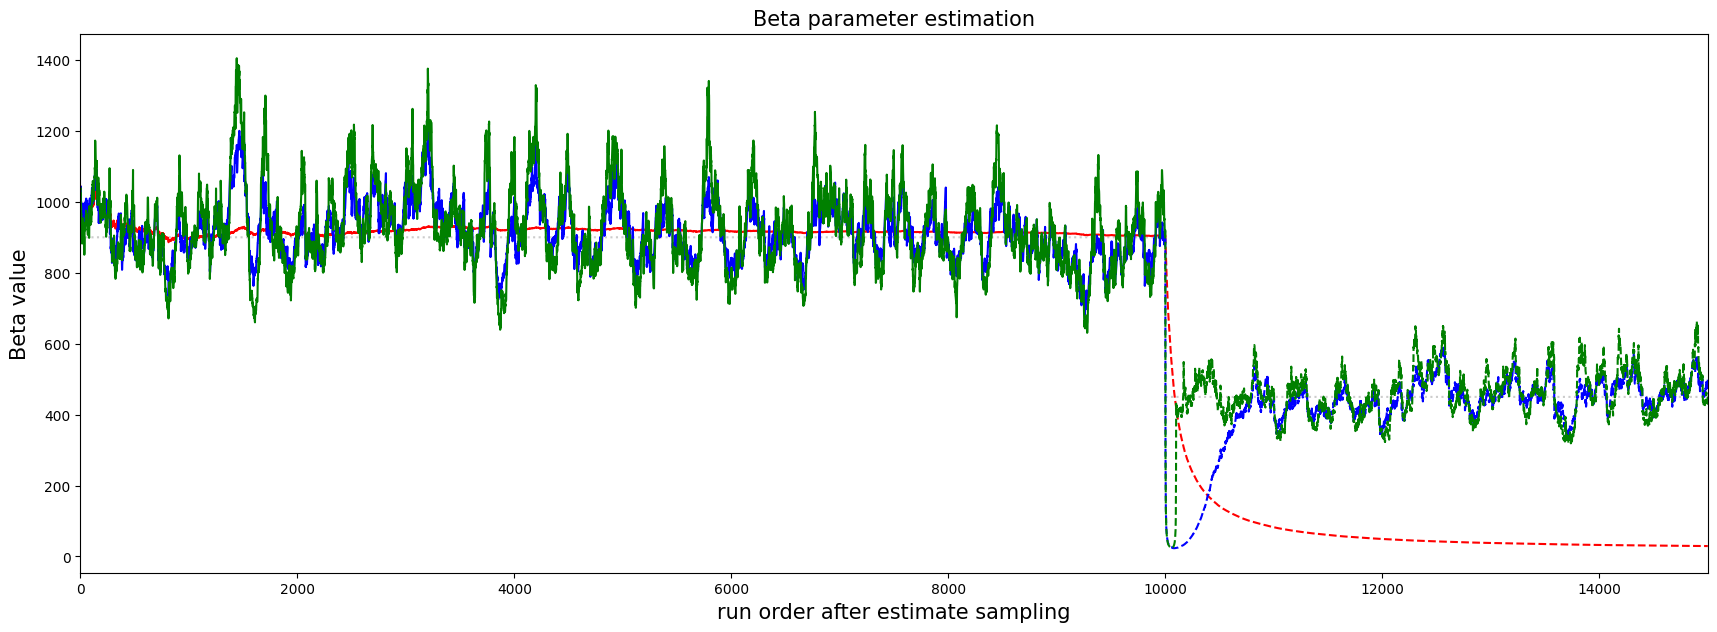

In [10]:
plt.figure(figsize=(21,7))
plt.xlim(0, 15000)
plt.plot(range(len(stable_sample)), [b1]*stable_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample),len(stable_sample)+len(novelty_sample)), [b2]*novelty_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample)), beta_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), beta_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), beta_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Beta parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Beta value', fontsize='15')
plt.show()

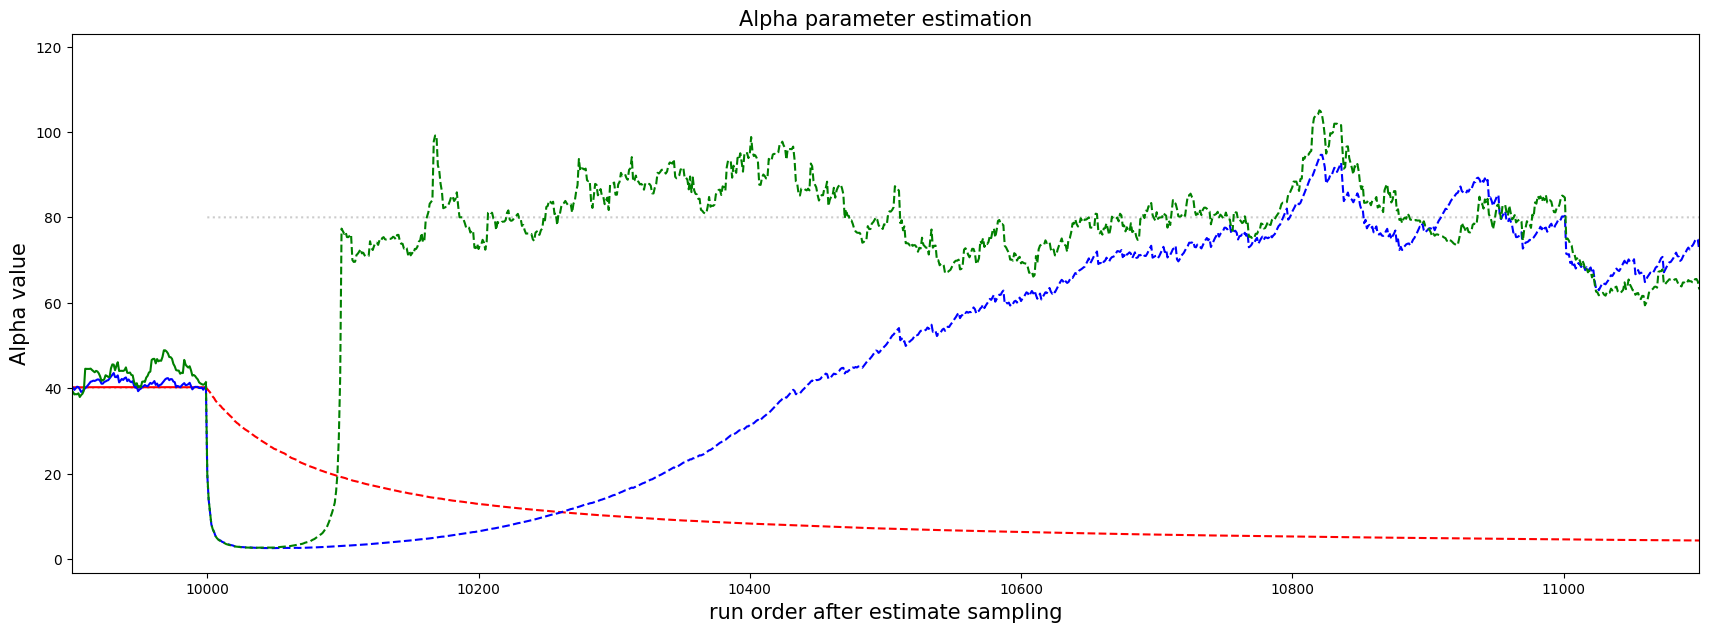

In [11]:
plt.figure(figsize=(21,7))
plt.xlim(9900, 11100)
plt.plot(range(len(stable_sample)), [a1]*stable_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample),len(stable_sample)+len(novelty_sample)), [a2]*novelty_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample)), alpha_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), alpha_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), alpha_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Alpha parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Alpha value', fontsize='15')
plt.show()

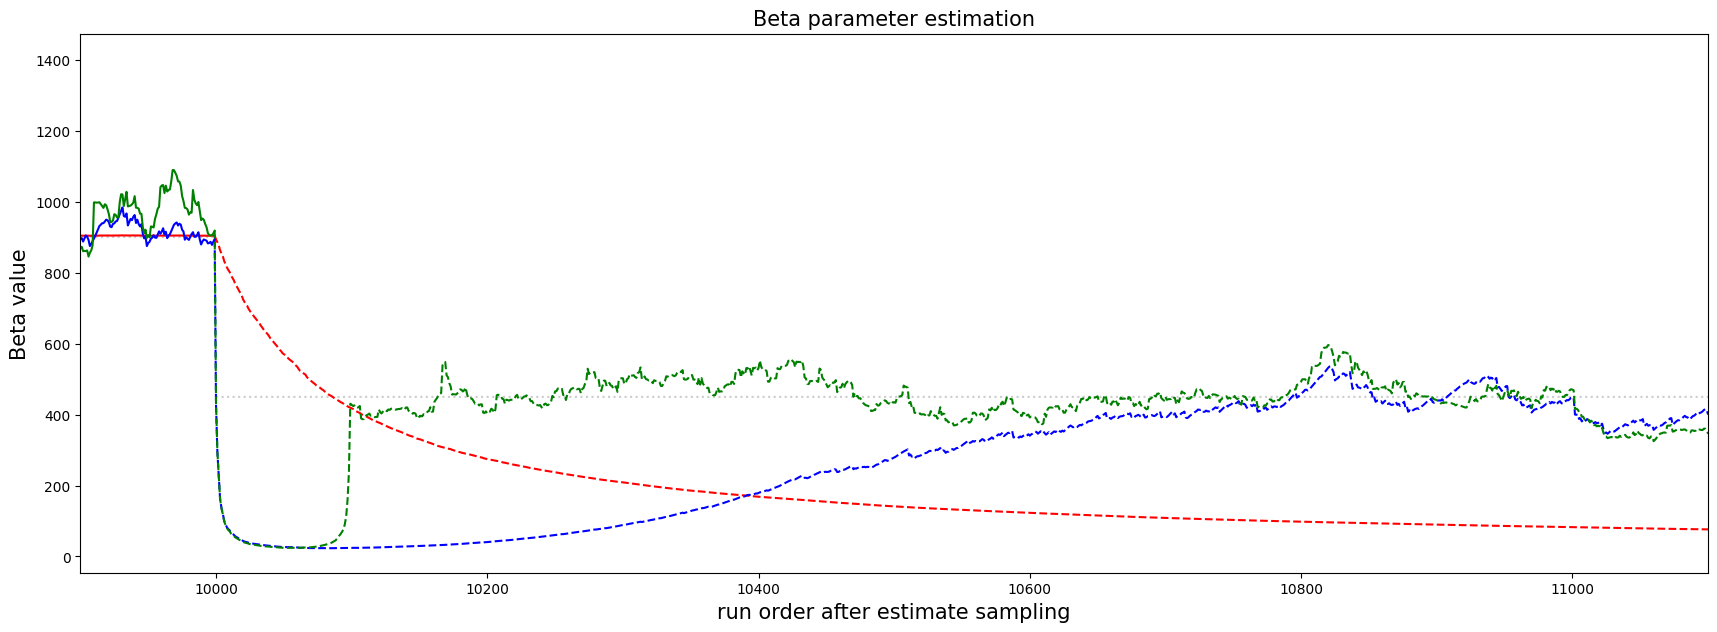

In [12]:
plt.figure(figsize=(21,7))
plt.xlim(9900, 11100)
plt.plot(range(len(stable_sample)), [b1]*stable_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample),len(stable_sample)+len(novelty_sample)), [b2]*novelty_sample.shape[0], '0.8', linestyle='dotted')
plt.plot(range(len(stable_sample)), beta_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), beta_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), beta_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Beta parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Beta value', fontsize='15')
plt.show()

In [13]:
alpha_estimates_truncated[9998:10010], alpha_estimates_window[9998:10010]

([40.02954628520063,
  40.37446487977865,
  19.749096868226346,
  13.929577806275717,
  11.037332004279397,
  8.112628555264806,
  7.0187113212465775,
  6.332872729391128,
  5.428460745636936,
  4.986059238758392,
  4.628703883318171,
  4.4103538285393995],
 [40.96381332354951,
  41.389745164075585,
  19.949819505438487,
  14.004034337475302,
  11.124744268892396,
  8.123096544333205,
  6.994697925187193,
  6.268129491931589,
  5.39083841327918,
  4.9203547003342765,
  4.5600881599950185,
  4.326476981073535])

In [14]:
#Animate the beta transitions

In [20]:
first_frame, last_frame = 9900, 10300

framed_time=slice(first_frame, last_frame)


frame_data = zip(alpha_estimates_proposed[framed_time], beta_estimates_proposed[framed_time],
                 alpha_estimates_truncated[framed_time], beta_estimates_truncated[framed_time],
                 alpha_estimates_window[framed_time], beta_estimates_window[framed_time], range(first_frame, last_frame))


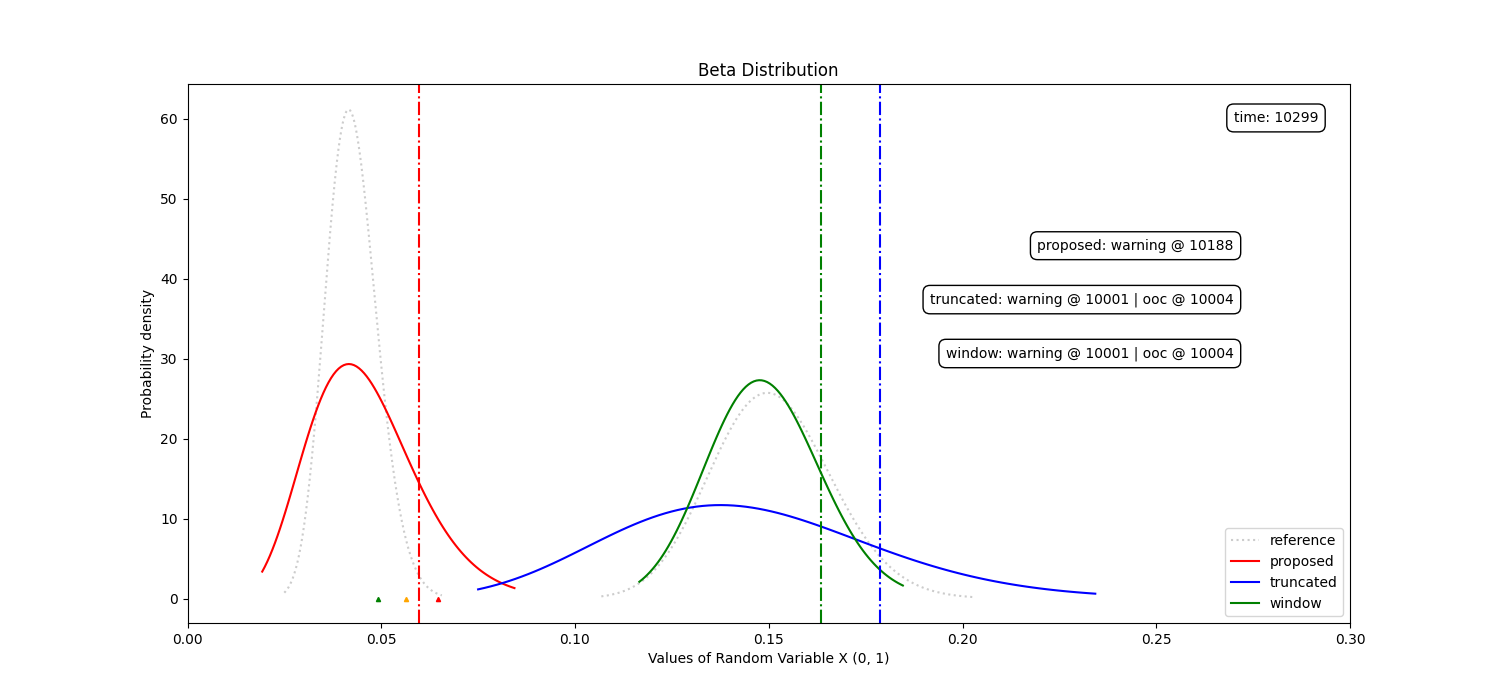

In [21]:
%matplotlib ipympl

import matplotlib.animation as animation
a_proposed , b_proposed, a_truncated, b_truncated, a_window, b_window, time = next(frame_data)


a1, b1 = 40, 900
a2, b2 = 80, 450

x1 = np.linspace(beta.ppf(0.001, a1, b1),beta.ppf(0.999, a1, b1), 1000)
y1 = beta.pdf(x1, a1, b1)
x2 = np.linspace(beta.ppf(0.001, a2, b2),beta.ppf(0.999, a2, b2), 1000)
y2 = beta.pdf(x2, a2, b2)

# As simplification, using fixed theoretical thresholds
z1, z2, z3 = 0.68, 0.95, 0.997
u1, u2, u3 = map(lambda x: beta.ppf(x, a1, b1), 
                            map(lambda x: (1+x)/2,
                                [z1, z2, z3]))

x_prop = np.linspace(beta.ppf(0.01, a_proposed, b_proposed),beta.ppf(0.99, a_proposed, b_proposed), 100)
y_prop = beta.pdf(x_prop, a_proposed, b_proposed)

x_trunc = np.linspace(beta.ppf(0.01, a_truncated, b_truncated),beta.ppf(0.99, a_truncated, b_truncated), 100)
y_trunc = beta.pdf(x_trunc, a_truncated, b_truncated)

x_wind = np.linspace(beta.ppf(0.01, a_window, b_window),beta.ppf(0.99, a_window, b_window), 100)
y_wind = beta.pdf(x_wind, a_window, b_window)

u1_prop = beta.pdf((1+z1)/2, a_window, b_window)
u1_trunc = beta.pdf((1+z1)/2, a_window, b_window)
u1_wind = beta.ppf((1+z1)/2, a_window, b_window)

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(x1, y1, '0.8', linestyle='dotted', label='reference')[0]
ax.plot(x2, y2, '0.8', linestyle='dotted')[0]

ax.plot([u1], [0], marker='^', markersize=3, color="green")
ax.plot([u2], [0], marker='^', markersize=3, color="orange")
ax.plot([u3], [0], marker='^', markersize=3, color="red")

line_prop = ax.plot(x_prop, y_prop, 'r-', label='proposed')[0]
line_trunc = ax.plot(x_trunc, y_trunc, 'b-', label='truncated')[0]
line_wind = ax.plot(x_wind, y_wind, 'g-', label='window')[0]

v_prop = ax.axvline(u1_prop, ymin=0, ymax= beta.pdf(u1_wind, a_proposed, b_proposed), color="r", linestyle="dashdot")
v_trunc = ax.axvline(u1_wind, ymin=0, ymax= beta.pdf(u1_wind, a_truncated, b_truncated), color="b", linestyle="dashdot")
v_wind = ax.axvline(u1_wind, ymin=0, ymax= beta.pdf(u1_wind, a_window, b_window), color="g", linestyle="dashdot")

ax.set(xlim=(0, 0.3), xlabel='Values of Random Variable X (0, 1)', ylabel='Probability density', title='Beta Distribution')
time_legend = ax.text(0.9, 0.95, f'time: {time}', ha='left', va='top', transform=ax.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

proposed_status_legend = ax.text(0.9, 0.7, 'proposed: in control', ha='right', va='center', transform=ax.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

truncated_status_legend = ax.text(0.9, 0.6, 'truncated: in control', ha='right', va='center', transform=ax.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

window_status_legend = ax.text(0.9, 0.5, 'window: in control', ha='right', va='center', transform=ax.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))

ax.legend(loc='lower right')

# Plot the beta distribution
def update(frame):

    a_proposed , b_proposed, a_truncated, b_truncated, a_window, b_window, time = frame
    # plt.xlim(0, 1)
    # plt.title('Beta Distribution', fontsize='15')
    # plt.xlabel('Values of Random Variable X (0, 1)', fontsize='15')
    # plt.ylabel('Probability', fontsize='15')
    
    
    x_prop = np.linspace(beta.ppf(0.01, a_proposed, b_proposed),beta.ppf(0.99, a_proposed, b_proposed), 100)
    y_prop = beta.pdf(x_prop, a_proposed, b_proposed)
    line_prop.set_data(x_prop, y_prop)
    u1_proposed = beta.ppf((1+z1)/2, a_proposed, b_proposed)
    v_prop.set_xdata([u1_proposed,u1_proposed]) 
    v_prop.set_ydata([0, beta.pdf(u1_proposed, a_proposed, b_proposed)])
    if u1_proposed <= u2:
        proposed_status_legend.set_text('proposed: in control')
    elif u1_proposed > u2 and ('proposed: warning' not in proposed_status_legend.get_text()):
        proposed_status_legend.set_text(f'proposed: warning @ {time}')
    elif u1_wind > u3 and ('ooc' not in proposed_status_legend.get_text()):
        proposed_status_legend.set_text(proposed_status_legend.get_text()+f' | ooc @ {time}')
    
    x_trunc = np.linspace(beta.ppf(0.01, a_truncated, b_truncated),beta.ppf(0.99, a_truncated, b_truncated), 100)
    y_trunc = beta.pdf(x_trunc, a_truncated, b_truncated)
    line_trunc.set_data(x_trunc, y_trunc)
    u1_truncated = beta.ppf((1+z1)/2, a_truncated, b_truncated)
    v_trunc.set_xdata([u1_truncated,u1_truncated]) 
    v_trunc.set_ydata([0, beta.pdf(u1_truncated, a_truncated, b_truncated)])
    if u1_truncated <= u2:
        truncated_status_legend.set_text(f'truncated: in control')
    elif u1_truncated > u2 and ('truncated: warning' not in truncated_status_legend.get_text()):
        truncated_status_legend.set_text(f'truncated: warning @ {time}')
    elif u1_truncated > u3 and ('ooc' not in truncated_status_legend.get_text()):
        truncated_status_legend.set_text(truncated_status_legend.get_text()+f' | ooc @ {time}')
    
    x_wind = np.linspace(beta.ppf(0.01, a_window, b_window),beta.ppf(0.99, a_window, b_window), 100)
    y_wind = beta.pdf(x_wind, a_window, b_window)
    line_wind.set_data(x_wind, y_wind)
    u1_window = beta.ppf((1+z1)/2, a_window, b_window)
    v_wind.set_xdata([u1_window,u1_window]) 
    v_wind.set_ydata([0, beta.pdf(u1_window, a_window, b_window)])
    if u1_window <= u2:
        window_status_legend.set_text(f'window: in control')
    elif u1_window > u2 and ('window: warning' not in window_status_legend.get_text()):
        window_status_legend.set_text(f'window: warning @ {time}')
    elif u1_window > u3 and ('ooc' not in window_status_legend.get_text()):
        window_status_legend.set_text(window_status_legend.get_text()+f' | ooc @ {time}')
        
    time_legend.set_text(f'time: {time}')
    
    return line_prop, line_trunc, line_wind, time_legend

#    plt.show()

anim = animation.FuncAnimation(fig, update, frames=list(frame_data), interval=100)
anim.save('./animations/beta_distribution.gif', writer='pillow')
plt.show()

In [17]:
anim.save('./animations/beta_distribution_control.mp4', writer='ffmpeg', fps=10)

In [18]:
len(stable_sample)

10000

In [ ]:
## How robust are alternatives?

In [ ]:
# setting the seed for reproducibility
np.random.seed(seed)

parameter_estimation_sample = beta.rvs(a1, b1, size=100)
stable_sample = beta.rvs(a1, b1, size=10000)
novelty_sample = beta.rvs(a2, b2, size=6000)

#replace with stable sample at // 1000

for i in (1000, 2000, 2001, 3000, 3001, 3002, 4000, 4001, 4002, 4003, 5000, 5001, 5002, 5003, 5004):
    novelty_sample[i] = beta.rvs(a1, b1)

In [ ]:
from src.change_detector.stats_and_distance.stats_and_distance import geo_mean

alpha_estimates_proposed = []
beta_estimates_proposed = []

run_order = len(parameter_estimation_sample)

dist_geo_mean, complementary_dist_geo_mean = geo_mean(parameter_estimation_sample), geo_mean([1-dist for dist in parameter_estimation_sample])

for dist in stable_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean)
    alpha_estimates_proposed.append(estimated_alpha)
    beta_estimates_proposed.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)
    
    
for dist in novelty_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean)
    alpha_estimates_proposed.append(estimated_alpha)
    beta_estimates_proposed.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)

In [ ]:
alpha_estimates_truncated = []
beta_estimates_truncated = []

#set max order value, "truncating" the geo mean estimation
order_limit = 100

run_order = len(parameter_estimation_sample)

dist_geo_mean, complementary_dist_geo_mean = geo_mean(parameter_estimation_sample), geo_mean([1-dist for dist in parameter_estimation_sample])

for dist in stable_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean, order_limit)
    alpha_estimates_truncated.append(estimated_alpha)
    beta_estimates_truncated.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)
    
    
for dist in novelty_sample:
    run_order += 1
    print("run order:", run_order)
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters(dist, run_order, dist_geo_mean, complementary_dist_geo_mean, order_limit)
    alpha_estimates_truncated.append(estimated_alpha)
    beta_estimates_truncated.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)

In [ ]:
alpha_estimates_window = []
beta_estimates_window = []

#set max order value, "truncating" the geo mean estimation
window_size= 100 #NOTE: should be smaller than starting window size of parameter_estimation_sample

run_order = len(parameter_estimation_sample)

dist_geo_mean, complementary_dist_geo_mean = geo_mean(parameter_estimation_sample), geo_mean([1-dist for dist in parameter_estimation_sample])

distances_window = parameter_estimation_sample.tolist()[-window_size:]

for dist in stable_sample:
    run_order += 1
    print("run order:", run_order)
    distances_window.append(dist)
    if len(distances_window) > window_size:
        distances_window.pop(0)
    # print(len(distances_window))
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters_window(distances_window)
    alpha_estimates_window.append(estimated_alpha)
    beta_estimates_window.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)
    
    
for dist in novelty_sample:
    run_order += 1
    print("run order:", run_order)
    distances_window.append(dist)
    distances_window.pop(0)    
    # print(len(distances_window))
    estimated_alpha, estimated_beta, dist_geo_mean, complementary_dist_geo_mean = update_beta_distribution_parameters_window(distances_window)
    alpha_estimates_window.append(estimated_alpha)
    beta_estimates_window.append(estimated_beta)
    print("new alpha:", estimated_alpha, "  new beta:", estimated_beta)
    print("geo_mean:", dist, "  complementary geo_mean:", 1-dist)

In [ ]:
plt.figure(figsize=(21,7))
plt.xlim(0, 16000)
plt.plot(range(len(stable_sample)), alpha_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), alpha_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), alpha_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Alpha parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Alpha value', fontsize='15')
plt.show()

In [ ]:
plt.figure(figsize=(21,7))
plt.xlim(0, 16000)
plt.plot(range(len(stable_sample)), beta_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), beta_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), beta_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Beta parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Beta value', fontsize='15')
plt.show()

In [ ]:
plt.figure(figsize=(21,7))
plt.xlim(9950, 16000)
plt.plot(range(len(stable_sample)), alpha_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), alpha_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), alpha_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), alpha_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Alpha parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Alpha value', fontsize='15')
plt.show()

In [ ]:
plt.figure(figsize=(21,7))
plt.xlim(9950, 16000)
plt.plot(range(len(stable_sample)), beta_estimates_proposed[:stable_sample.shape[0]], 'r-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_proposed[-novelty_sample.shape[0]-1:], 'r--')
plt.plot(range(len(stable_sample)), beta_estimates_truncated[:stable_sample.shape[0]], 'b-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_truncated[-novelty_sample.shape[0]-1:], 'b--')
plt.plot(range(len(stable_sample)), beta_estimates_window[:stable_sample.shape[0]], 'g-')
plt.plot(range(len(stable_sample)-1,len(stable_sample)+len(novelty_sample)), beta_estimates_window[-novelty_sample.shape[0]-1:], 'g--')
plt.title("Beta parameter estimation", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('Beta value', fontsize='15')
plt.show()

In [ ]:
transition_sample = [(stable_sample[-100+n:], novelty_sample[:n]) for n in range(100)]+[(np.empty(0,), novelty_sample[:100])]

In [ ]:

mean_1, var_1 = beta.stats(a1,b1,moments='mv')
mean_2, var_2 = beta.stats(a2,b2,moments='mv')
mean_1, var_1, mean_2, var_2

In [ ]:
#Theoretical mixture mean and variance:

n=100

mixture_moments = [((n-i)*mean_1/n + (i)*mean_2/n, (n-i)*var_1/n + i*var_2/n + ((mean_1-mean_2)**2)*(i*(n-i))/n) for i in range(1,100)]
mixture_moments

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(range(0,101), [mean_1]+[x[0] for x in mixture_moments]+[mean_2], 'r-')
plt.plot(range(0,101), [var_1]+[x[1] for x in mixture_moments]+[var_2], 'b-')
plt.title("Moments of the mixture", fontsize='15')
plt.xlabel('run order after estimate sampling', fontsize='15')
plt.ylabel('moments value', fontsize='15')
plt.legend(['mean', 'variance'])
plt.show()

In [ ]:
transition_alphas = [a1]+[x[0]*(((x[0]*(1-x[0]))/x[1])-1) for x in mixture_moments]+[a2]
transition_betas = [b1]+[(1-x[0])*(((x[0]*(1-x[0]))/x[1])-1) for x in mixture_moments]+[b2]
transition_alphas, transition_betas

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(range(0,101), transition_alphas, 'r-')
plt.plot(range(0,101), transition_betas, 'b-')
plt.plot(range(0,101), alpha_estimates_window[9999:10100], 'r--')
plt.plot(range(0,101), beta_estimates_window[9999:10100], 'b--')
plt.title("Beta parameter estimation", fontsize='15')
plt.xlabel('index within transition', fontsize='15')
plt.ylabel('parameter value', fontsize='15')
plt.legend(['alpha', 'beta', 'alpha_window', 'beta_window'])
plt.show()

In [ ]:
len(transition_alphas) #= 101 (indexes from 10000 to 10100)


In [ ]:
first_frame, last_frame = 9900, 11100

transition_start_index = 10000
transition_end_index = 10100

framed_time=slice(first_frame, last_frame)

alpha_theorical = (transition_start_index-first_frame-1)*[a1]+transition_alphas+(last_frame-transition_end_index)*[a2]
beta_theorical = (transition_start_index-first_frame-1)*[b1]+transition_betas+(last_frame-transition_end_index)*[b2]

frame_data = zip(alpha_estimates_proposed[framed_time], beta_estimates_proposed[framed_time],
                 alpha_estimates_truncated[framed_time], beta_estimates_truncated[framed_time],
                 alpha_estimates_window[framed_time], beta_estimates_window[framed_time],
                 alpha_theorical, beta_theorical,
                 range(first_frame, last_frame))

frame_data_list = list(frame_data)

In [ ]:
len(alpha_estimates_window[9900:11100])

In [ ]:
len(alpha_theorical), len(beta_theorical)

In [ ]:

%matplotlib ipympl

import matplotlib.animation as animation
a_proposed , b_proposed, a_truncated, b_truncated, a_window, b_window, alpha_theorical, beta_theorical, time = next(frame_data)


a1, b1 = 40, 900
a2, b2 = 80, 450

x1 = np.linspace(beta.ppf(0.01, a1, b1),beta.ppf(0.99, a1, b1), 100)
y1 = beta.pdf(x1, a1, b1)
x2 = np.linspace(beta.ppf(0.01, a2, b2),beta.ppf(0.99, a2, b2), 100)
y2 = beta.pdf(x2, a2, b2)

x_prop = np.linspace(beta.ppf(0.01, a_proposed, b_proposed),beta.ppf(0.99, a_proposed, b_proposed), 100)
y_prop = beta.pdf(x_prop, a_proposed, b_proposed)

x_trunc = np.linspace(beta.ppf(0.01, a_truncated, b_truncated),beta.ppf(0.99, a_truncated, b_truncated), 100)
y_trunc = beta.pdf(x_trunc, a_truncated, b_truncated)

x_wind = np.linspace(beta.ppf(0.01, a_window, b_window),beta.ppf(0.99, a_window, b_window), 100)
y_wind = beta.pdf(x_wind, a_window, b_window)

x_theo = np.linspace(beta.ppf(0.01, alpha_theorical, beta_theorical),beta.ppf(0.99, alpha_theorical, beta_theorical), 100)
y_theo = beta.pdf(x_theo, alpha_theorical, beta_theorical)

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(x1, y1, '0.8', linestyle='dotted', label='reference')[0]
ax.plot(x2, y2, '0.8', linestyle='dotted')[0]

line_prop = ax.plot(x_prop, y_prop, 'r-', label='proposed')[0]
line_trunc = ax.plot(x_trunc, y_trunc, 'b-', label='truncated')[0]
line_wind = ax.plot(x_wind, y_wind, 'g-', label='window')[0]
line_theo = ax.plot(x_theo, y_theo, 'k-', label='theoretical')[0]

ax.set(xlim=(0, 1), xlabel='Values of Random Variable X (0, 1)',
       ylim=(0,200), ylabel='Probability density', title='Beta Distribution')
time_legend = ax.text(0.9, 0.95, f'time: {time}', ha='left', va='top', transform=ax.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
ax.legend(loc='lower right')

# Plot the beta distribution
def update(frame):

    a_proposed , b_proposed, a_truncated, b_truncated, a_window, b_window, alpha_theorical, beta_theorical, time = frame
    # plt.xlim(0, 1)
    # plt.title('Beta Distribution', fontsize='15')
    # plt.xlabel('Values of Random Variable X (0, 1)', fontsize='15')
    # plt.ylabel('Probability', fontsize='15')
    
    
    x_prop = np.linspace(beta.ppf(0.01, a_proposed, b_proposed),beta.ppf(0.99, a_proposed, b_proposed), 100)
    y_prop = beta.pdf(x_prop, a_proposed, b_proposed)
    line_prop.set_data(x_prop, y_prop)
    
    x_trunc = np.linspace(beta.ppf(0.01, a_truncated, b_truncated),beta.ppf(0.99, a_truncated, b_truncated), 100)
    y_trunc = beta.pdf(x_trunc, a_truncated, b_truncated)
    line_trunc.set_data(x_trunc, y_trunc)
    
    x_wind = np.linspace(beta.ppf(0.01, a_window, b_window),beta.ppf(0.99, a_window, b_window), 100)
    y_wind = beta.pdf(x_wind, a_window, b_window)
    line_wind.set_data(x_wind, y_wind)
    
    x_theo = np.linspace(beta.ppf(0.01, alpha_theorical, beta_theorical),beta.ppf(0.99, alpha_theorical, beta_theorical), 100)
    y_theo = beta.pdf(x_theo, alpha_theorical, beta_theorical)
    line_theo.set_data(x_theo, y_theo)
    
    time_legend.set_text(f'time: {time}')
    
    return line_prop, line_trunc, line_wind, time_legend

#    plt.show()

anim = animation.FuncAnimation(fig, update, frames=list(frame_data), interval=100)
anim.save('./animations/beta_distribution_with_theo.gif', writer='pillow')
plt.show()

In [ ]:
anim.save('./animations/beta_distribution_with_theo.mp4', writer='ffmpeg', fps=10)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.widgets import Button, Slider


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

In [ ]:
#Slider widget plot

%matplotlib ipympl

from matplotlib.widgets import Button, Slider

a_proposed , b_proposed, a_truncated, b_truncated, a_window, b_window, alpha_theorical, beta_theorical, start_time = frame_data_list[0]

end_time = frame_data_list[-1][-1]

a1, b1 = 40, 900
a2, b2 = 80, 450

x1 = np.linspace(beta.ppf(0.01, a1, b1),beta.ppf(0.99, a1, b1), 100)
y1 = beta.pdf(x1, a1, b1)
x2 = np.linspace(beta.ppf(0.01, a2, b2),beta.ppf(0.99, a2, b2), 100)
y2 = beta.pdf(x2, a2, b2)

x_prop = np.linspace(beta.ppf(0.01, a_proposed, b_proposed),beta.ppf(0.99, a_proposed, b_proposed), 100)
y_prop = beta.pdf(x_prop, a_proposed, b_proposed)

x_trunc = np.linspace(beta.ppf(0.01, a_truncated, b_truncated),beta.ppf(0.99, a_truncated, b_truncated), 100)
y_trunc = beta.pdf(x_trunc, a_truncated, b_truncated)

x_wind = np.linspace(beta.ppf(0.01, a_window, b_window),beta.ppf(0.99, a_window, b_window), 100)
y_wind = beta.pdf(x_wind, a_window, b_window)

x_theo = np.linspace(beta.ppf(0.01, alpha_theorical, beta_theorical),beta.ppf(0.99, alpha_theorical, beta_theorical), 100)
y_theo = beta.pdf(x_theo, alpha_theorical, beta_theorical)

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(x1, y1, '0.8', linestyle='dotted', label='reference')[0]
ax.plot(x2, y2, '0.8', linestyle='dotted')[0]

line_prop = ax.plot(x_prop, y_prop, 'r-', label='proposed')[0]
line_trunc = ax.plot(x_trunc, y_trunc, 'b-', label='truncated')[0]
line_wind = ax.plot(x_wind, y_wind, 'g-', label='window')[0]
line_theo = ax.plot(x_theo, y_theo, 'k-', label='theoretical')[0]

ax.set(xlim=(0, 0.4), xlabel='Values of Random Variable X (0, 1)',
       ylim=(0,100), ylabel='Probability density', title='Beta Distribution')
time_legend = ax.text(0.9, 0.95, f'time: {start_time}', ha='left', va='top', transform=ax.transAxes,
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
ax.legend(loc='lower right')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Time step',
    valmin=start_time,
    valmax=end_time,
    valinit=start_time,
)
# Plot the beta distribution
def update(val):
    idx = int(freq_slider.val-start_time)
    a_proposed , b_proposed, a_truncated, b_truncated, a_window, b_window, alpha_theorical, beta_theorical, time = frame_data_list[idx]
    # plt.xlim(0, 1)
    # plt.title('Beta Distribution', fontsize='15')
    # plt.xlabel('Values of Random Variable X (0, 1)', fontsize='15')
    # plt.ylabel('Probability', fontsize='15')
    
    
    x_prop = np.linspace(beta.ppf(0.01, a_proposed, b_proposed),beta.ppf(0.99, a_proposed, b_proposed), 100)
    y_prop = beta.pdf(x_prop, a_proposed, b_proposed)
    line_prop.set_data(x_prop, y_prop)
    
    x_trunc = np.linspace(beta.ppf(0.01, a_truncated, b_truncated),beta.ppf(0.99, a_truncated, b_truncated), 100)
    y_trunc = beta.pdf(x_trunc, a_truncated, b_truncated)
    line_trunc.set_data(x_trunc, y_trunc)
    
    x_wind = np.linspace(beta.ppf(0.01, a_window, b_window),beta.ppf(0.99, a_window, b_window), 100)
    y_wind = beta.pdf(x_wind, a_window, b_window)
    line_wind.set_data(x_wind, y_wind)
    
    x_theo = np.linspace(beta.ppf(0.01, alpha_theorical, beta_theorical),beta.ppf(0.99, alpha_theorical, beta_theorical), 100)
    y_theo = beta.pdf(x_theo, alpha_theorical, beta_theorical)
    line_theo.set_data(x_theo, y_theo)
    
    time_legend.set_text(f'time: {time}')
    
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
button.on_clicked(reset)

plt.show()

In [ ]:
from src.change_detector.control_state import ControlState
import pandas as pd
from scipy.stats import beta
from scipy.spatial.distance import jensenshannon
from src.change_detector.stats_and_distance.stats_and_distance import JSD_distance, iter_geo_mean_estimator, geo_mean

class PDFChangeDetector:
    def __init__(self, a_memory:float=0.5, z1=0.68, z2=0.95, z3=0.997, window_size=100) -> None:
        
        #quantile parameters
        self._z1 = z1
        self._z2 = z2
        self._z3 = z3
        
        # alpha fading memory parameter and attributes
        self.a_memory:float = a_memory
        self._alpha_fading_pdf:pd.Series|None = None
        
        # Beta distribution parameters
        self._estimated_alpha:float|None = None
        self._estimated_beta:float|None = None
        
        # Stochastic process parameters and attributes
        self._run_order = 1
        
        self._reference_PDF = None
        
        self._dist_geo_mean:float|None = None
        self._complementary_dist_geo_mean:float|None = None
        
        self._min_u1 = None
        self._min_u2 = None
        self._min_u3 = None
        
        self._monitor_window_size = window_size
        self._monitor_window_distances = np.empty(self._monitor_window_size)
        self._probable_new_process_memory
        
    def _update_alpha_fading_pdf(self, 
                            current_pdf:pd.Series
                            ) -> None:
        damped_hist = self._alpha_fading_pdf*self.a_memory
        self._alpha_fading_pdf = (damped_hist + current_pdf)/(1+self.a_memory)
        
    @property
    def alpha_fading_pdf(self) -> pd.Series|None:
        return self._alpha_fading_pdf
        
    def _update_beta_distribution_parameters(self,
                                new_dist: float, 
                                # order:int, 
                                # old_dist_geo_mean:float, 
                                # old_complementary_dist_geo_mean:float
                                ) -> None:
        
        if self._run_order == 1:
            self._dist_geo_mean, self._complementary_dist_geo_mean = new_dist, 1-new_dist
        else:    
            self._update_geo_mean_estimators(new_dist)
            self._estimated_alpha = 1/2*(1+self._dist_geo_mean/(1-self._dist_geo_mean-self._complementary_dist_geo_mean))
            self._estimated_beta =  1/2*(1+self._complementary_dist_geo_mean/(1-self._dist_geo_mean-self._complementary_dist_geo_mean))
        # print("new alpha:", self._estimated_alpha, "  new beta:", self._estimated_beta)
        # print("geo_mean:", self._dist_geo_mean, "  complementary geo_mean:", self._complementary_dist_geo_mean)
            
    def _reset_detector_parameters(self, ref_PDF:pd.Series) -> None:
        self._estimated_alpha = None
        self._estimated_beta = None
        self._dist_geo_mean = None
        self._complementary_dist_geo_mean = None
        self._run_order = 1
        self._alpha_fading_pdf = None
        self._reference_PDF = ref_PDF
        self._alpha_fading_pdf = ref_PDF
        self._min_u1, self._min_u2, self._min_u3 = None, None, None
        self._monitor_window = np.array()
        
    def _update_geo_mean_estimators(self, new_dist: float) ->None:
        self._dist_geo_mean, self._complementary_dist_geo_mean = (
            iter_geo_mean_estimator(x1, self._run_order, x2) for x1, x2 in
            [(new_dist, self._dist_geo_mean), (1-new_dist, self._complementary_dist_geo_mean)]
        )
    
    def detect_change(self,new_pdf:pd.Series) -> tuple[ControlState, float|None, float|None]:
        
        if self._reference_PDF is None:
            self._reset_detector_parameters(new_pdf)
            # print("First pdf taken as reference.")
            return ControlState.IN_CONTROL, self._estimated_alpha, self._estimated_beta
        else:
            self._update_alpha_fading_pdf(new_pdf)
            pdf_dist = JSD_distance(self._reference_PDF, self._alpha_fading_pdf)
            # print("PDF distance:", pdf_dist, "current_order:", self._run_order)
            # print("JSD_distance:", jensenshannon(self._reference_PDF, self._alpha_fading_pdf, base=2)) # alternatively
            self._update_beta_distribution_parameters(pdf_dist)
            self._run_order += 1
            if not all([self._estimated_alpha, self._estimated_beta]):
                # print("Only one distance estimator is available.")
                return ControlState.IN_CONTROL, self._estimated_alpha, self._estimated_beta
            u1, u2, u3 = map(lambda x: beta.ppf(x, self._estimated_alpha, self._estimated_beta), 
                            map(lambda x: (1+x)/2,
                                [self._z1, self._z2, self._z3]))
            if not any([self._min_u1, self._min_u2, self._min_u3]) or u1 < self._min_u1:
                self._min_u1, self._min_u2, self._min_u3 = u1, u2, u3
            # print("current u1:", u1)
            # print("min u1:", self._min_u1, "  min u2:", self._min_u2, "  min u3:", self._min_u3)
            if u1 < self._min_u2:
                return ControlState.IN_CONTROL, self._estimated_alpha, self._estimated_beta
            elif u1 < self._min_u3:
                return ControlState.WARNING, self._estimated_alpha, self._estimated_beta
            else:
                self._reset_detector_parameters(new_pdf)
                # print("Out of control. New pdf taken as reference.")
                return ControlState.OUT_OF_CONTROL, self._estimated_alpha, self._estimated_beta